# CropHarvest Demo

**Authors**: Gabriel Tseng, Ivan Zvonkov

**Description**: This notebook demonstrates the capabilities of the CropHarvest package by training and testing a model on a subset of the data and then running inference using the trained model.

In [1]:
from cropharvest.datasets import CropHarvest
from cropharvest.inference import Inference
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier

import requests
import tempfile

DATA_DIR = "data"

## Load datasets

In [2]:
evaluation_datasets = CropHarvest.create_benchmark_datasets(DATA_DIR)
evaluation_datasets

[CropHarvestEval(Kenya_1_maize, Kenya_maize),
 CropHarvestEval(Brazil_0_coffee, Brazil_coffee),
 CropHarvestEval(Togo_crop, togo-eval)]

## Split Togo data into X and y

In [3]:
togo_dataset = evaluation_datasets[-1]
X, y = togo_dataset.as_array(flatten_x=True)
X.shape, y.shape

((1290, 216), (1290,))

## Train a Random Forest model on the Togo dataset

In [4]:
model = RandomForestClassifier(random_state=0)
model.fit(X, y)

RandomForestClassifier(random_state=0)

## Make predictions on Togo test set

In [5]:
test_preds, test_instances = [], []
for _, test_instance in togo_dataset.test_data(flatten_x=True):
    test_preds.append(model.predict_proba(test_instance.x)[:, 1])
    test_instances.append(test_instance)
    
print(
    f"For the Random Forest classifier, "
    f"{test_instances[0].evaluate_predictions(test_preds[0])}, "
)

For the Random Forest classifier, {'auc_roc': 0.8954952830188679, 'f1_score': 0.7401574803149605, 'iou': 0.5875, 'num_samples': 306}, 


## Get test file for inference

In [6]:
test_file = "98-togo_2019-02-06_2020-02-01.tif"

temp_dir = tempfile.gettempdir()
p = Path(temp_dir) / test_file
response = requests.get(
    f"https://github.com/nasaharvest/cropharvest/blob/main/test/cropharvest/{test_file}?raw=true", 
)
with p.open("wb") as f:
    f.write(response.content)

## Run inference

In [7]:
preds = Inference(model=model).run(p)
preds

<xarray.Dataset>
Dimensions:       (lat: 17, lon: 17)
Coordinates:
  * lat           (lat) float64 7.719 7.719 7.719 7.719 ... 7.72 7.72 7.72 7.72
  * lon           (lon) float64 1.422 1.422 1.422 1.422 ... 1.423 1.423 1.424
Data variables:
    prediction_0  (lat, lon) float64 0.26 0.27 0.27 0.27 ... 0.28 0.28 0.28 0.28

## [Optional] Visualize model prediction

In [8]:
!pip install matplotlib -q

google-api-python-client 1.12.8 has requirement google-api-core<2dev,>=1.21.0, but you'll have google-api-core 2.3.2 which is incompatible.
You are using pip version 10.0.1, however version 22.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [9]:
import matplotlib.pyplot as plt

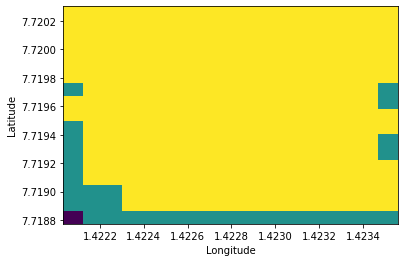

In [10]:
preds_np = preds.to_array()[0]
plt.pcolormesh(preds_np.lon, preds_np.lat, preds_np.data)
plt.xlabel("Longitude")
plt.ylabel("Latitude");